### Toy Damage Estimator: A Simple Machine Learning approach
A toy earthquake damage estimator. There is a ton of literature on this, but for now, we are going to take some liberties, assume some strength and damange probability models, and things like that. We will construct some realities -- based on best guesses, but made up nonetheless.

Some assumptions:
- Buildings will be assigned characteristics from a (short) list of properties. Some of these properties are "or" selected (ie, a building can be either build of "wood framing", "block or brick", "reinforced (masonry, block, or brick)", maybe "brick over framing").
    - In future versions, we might allow mixed constructions (we'll talk about that later)
    - We can also discuss the construction classifiers. These might be selected to optimize for financial damage vs dangerous structural damage. For example, brick facad over wood frame probably has similar structual properties as wood framing, but might suffer more cosmetic damage when exposed to mild shaking.
- We compute the strength of a building by summing the strength values of its components; some of these might be negative -- for example, "living space over garage" (LSoG).

\begin{equation}
S = \sum_j {s_j}
\end{equation}

- So we have a set of houses, and we know their strengths. Compute their probability of failure from something simple, like a Poisson distribution,

\begin{equation}
P_{fail}(I,S) = 1 - e^{\alpha {\frac{I}{S}}}
\end{equation}

where $I$ is the local shaking intensity and $S$ is the total strength of the building, and $\alpha$ is a parameter.
- For now, let's thing "houses", aka small, one or two story buildings, no steel frame and glass type construction, etc.


In [15]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

import numpy
import scipy
import pylab as plt
import sklearn
import pandas
import random

import datetime as dtm
import matplotlib.dates as mpd

import os
import sys

class PRandom(object):
    def __init__(self, lo=0., hi=1., seed=None):
        # todo: we should also allow a seed parameter (which i think we call 'seed')
        #super(PRandom,self).__init__(seed)
        self.R = random.Random(seed)
        self.hi = max(hi,lo)
        self.lo = min(hi,lo)
        self.dx = hi-lo
    #
    def random(self):
        #return self.lo + self.dx*super(PRandom,self).random()
        return self.lo + self.dx*self.R.random()
    #

#

### ML Step 1, Gather (create some) the data:
- Assume a simple model for building strength (see above)
- Create training and target sets. For the training set, we will know which elements fail. 

In [16]:
#
# make up some strengths:
building_strengths = {'wood_frame':5., 'block':3., 'reinforced':7., 'concrete':4}
#
LSOG_strengths = {0:0., 1:-1.}
#
class Threshold_getter(list):
    #
    def __init__(self, X):
        '''
        # input X: a 2xN list of key,val pairs: [[key,val], [key,val], ...]
        # we will sort them by key so that when we .get_val(x), we get the (key,val) pair where
        # x>= key_j (and therefore < key_{j+1}).
        '''
        # handle a non-list input... even though it will except or error off down the line (we might be
        # better off just letting this break if it's passed nonsense).
        if not hasattr(X,'__len__'): X = [X]
        #
        # initialize the list part of self:
        super(Threshold_getter,self).__init__(X)
        #
        self.sort(key=lambda rw:rw[0])
    #
    def get_val(self,x, verbose=False):
        #return the (key,val) pari from self such that x>=key_j. for now, just spin through the list.
        # a faster search algorithm would be a Newtonian type, where we bisect the search space at each
        # step, so we get ~log(N) performance, rather than N performance.
        #
        #r_val = self[0]
        j=0
        while x>=self[j][0]:
            #
            j+=1
            if j>=len(self): break
        if verbose:
            return self[max(max(0,j-1), len(self)-1)]
        else:
            return self[max(max(0,j-1), len(self)-1)][1]
    
    def test_me(self, xs=None):
        if xs is None:
            R = random.Random()
            y0,y1 = sorted([rw[0] for rw in self])[0::len(self)-1]
            print('**DEBUG: ', y0, y1)
            dy=y1-y0
            #
            xs = [y0 + dy*R.random() for _ in range(10)] + [y0 - dy*R.random() for _ in range(10)] + [y1 + dy*R.random() for _ in range(10)] 
            
            xs.sort()
        #
        return [[x,self.get_val(x, verbose=True)] for x in xs]
#
year_strengths = Threshold_getter([[1950,-1], [1970,1], [1990,0], [2000,-1], [2010,1.5]])
n_floors_strengths = Threshold_getter([[1,0.], [2, -.5], [3, -1.]])
retro_fit_strengths = Threshold_getter([[0.,0.], [1., 1], [2.,2.]])   # assume we can have degrees of retrofit...
#
class House(object):
    # maybe inherit from list() or maybe dict() so we get a useful default behavior.
    def __init__(self, construction='wood_frame', year_built=2000., LSOG=0, n_floors=1, retro_fitted=0,
                building_strengths=building_strengths, year_strengths=year_strengths,
                 n_floors_strengths=n_floors_strengths, retro_fit_strengths=retro_fit_strengths,
                LSOG_strengths=LSOG_strengths):
        s_construct = building_strengths.get(construction,5.)
        #
        # year built: assume there were some good years and bad years. we would do ML study of just age
        # to identify the best years. ironically, older houses might fare better, since the crappy older
        # houses probably already fell down. but for now, we're making this up:
        s_year      = year_strengths.get_val(year_built)
        #
        # assume LSOG is boolean.
        s_LSOG      = LSOG_strengths.get(LSOG,0.)
        s_floors = n_floors_strengths.get_val(n_floors)
        s_retro = retro_fit_strengths.get_val(retro_fitted)
        #
        strength = s_construct + s_year + s_LSOG + s_floors + s_retro
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
    #
#
# let's make some training houses. for now, same number of each construction type; we'll do more or less
# even distributions of each parameter.


# make a training set:
#
R_year   = PRandom(1940., 2017.)
R_LSOG   = PRandom(0.,1)
R_floors = PRandom(0., 3.)
R_retro  = PRandom(0.,2.)
#
training_houses = []
N_training = 25
for c_type in building_strengths.keys():
    training_houses += [House(construction=c_type, year_built=R_year.random(), LSOG=int(round(R_LSOG.random())),
                             n_floors=max(1, int(round(R_floors.random()))), retro_fitted=R_retro.random())
                        for _ in range(N_training)]

y0, dy = 1950., 70.

#
# and a target set (which will be a lot like the training set for now):
R_year   = PRandom(1930., 2017.)
R_LSOG   = PRandom(0.,1)
R_floors = PRandom(0., 3.)
R_retro  = PRandom(0.,2.)
#
target_houses = []
N_target = 250
y0, dy = 1950., 70.
#
for c_type in building_strengths.keys():
    target_houses += [House(construction=c_type, year_built=R_year.random(), LSOG=int(round(R_LSOG.random())),
                             n_floors=max(1, int(round(R_floors.random()))), retro_fitted=R_retro.random(),
                           building_strengths=building_strengths, year_strengths=year_strengths)
                        for _ in range(N_target)]
    #
#
# ... and make an additional set of target data from a slightly different strength model;
# they have weaker wood and poor concrete.:
building_strengths2 = {'wood_frame':4., 'block':3.5, 'reinforced':7, 'concrete':3}
#
# and let's just shift the year-strengths by a few years:
#year_strengths2 = {key-5:val for key,val in year_strengths}
year_strengths2 = year_strengths = Threshold_getter([[key,val] for key,val in year_strengths])
LSOG_strengths = {0:0, 1:-1.5}
#
target_houses2 = []
N_target = 250
y0, dy = 1950., 70.
#
for c_type in building_strengths.keys():
    target_houses2 += [House(construction=c_type, year_built=R_year.random(), LSOG=int(round(R_LSOG.random())),
                             n_floors=max(1, int(round(R_floors.random()))), retro_fitted=R_retro.random(),
                           building_strengths=building_strengths2, year_strengths=year_strengths2)
                        for _ in range(N_target)]
#       

print(len(training_houses), len(target_houses))

100 1000


### ML Step 2, Filter data:
- Not really any filtering to do, since we're making up the data in the first place.

### ML Step 3 Identify and/or create features
- In this case, we know the features from the data creation step, but they are not necessarily the same. We might need to regroup construction types, year_built, etc.
- Write functions to create the model array(s) and survived/faild vectors

In [17]:
def get_model_array(houses, year_strengths=year_strengths, retro_thresh=.7, LSOG_thresh=1.):
    # construct and return a binary model array. construction gets expanded to something like,
    # [is_wood, is_block, ...]
    # these are the arrays we will actually plug into the training/prediction steps.
    A = []
    #
    for h in houses:
        rw = [h.construction==c for c in ['wood_frame', 'block', 'reinforced', 'concrete']]
        if not 1 in rw:
            rw += [1]
        else:
            rw += [0]
        #
        # year build categories:
        yrs = sorted([x[0] for x in year_strengths])
        rw += [h.year_built<yrs[0]]
        rw += [(h.year_built>=yrs[j] and h.year_built<y) for j,y in enumerate(yrs[1:])]
        rw += [h.year_built>=yrs[-1]]
        #
        rw += [h.LSOG >= LSOG_thresh]
        #
        rw += [int(h.n_floors)==1, int(h.n_floors)==2, h.n_floors>=3]
        #
        rw += [h.retro_fitted >= retro_thresh]
        #
        rw = [int(x) for x in rw]
        #
        A += [rw]
    #
    return A

def get_survived_vector_simple(houses, frac_failed=.5):
    #
    # fail the lower frac_failed elements.
    # probably the fastest way to do this is to make an index, sort by value, truncate at frac_failed,
    # and then re-sort by index. but since this is just a toy program, we're just going to make a copy,
    # sort, get the frac_failed value, and then return a binary vector.
    #
    strengths = sorted([h.strength for h in houses])
    s_0 = strengths[int(frac_failed*len(houses))]
    #
    return [int(h.strength>s_0) for h in houses]
        

In [18]:
frac_fail = .5
A_training = get_model_array(houses=training_houses)
survived_training = get_survived_vector_simple(houses=training_houses, frac_failed=frac_fail)
#

### ML step 4, Training:
- Train the linear model by regressing the known survival vector against the model array


In [19]:
prms_predict = numpy.linalg.lstsq(A_training,survived_training)
#

### ML Step 5: Predict
- A fancy way of saying, dot the model array with the best-fit parameters from the "training" step.
- In a real code-base, this would be written out into Class() definitions
- ... and we'd probably use an sklearn "pipeline" class, with all it's "train" and "predict" functions.
- Note, in our plot, we'll see groups for different strength classes. Since construction material dominates our strength model, we'll see a group for each of those. Note also, that one step in the ML process might be to identify these groups, nominally via some sort of clustering and/or PCA method.


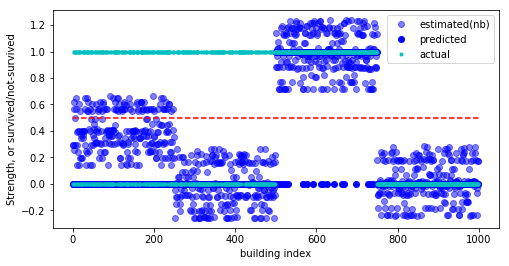

In [20]:
# Predict the damaged houses by dotting the Target array with the best fit training parameters.
A_target  =  get_model_array(houses=target_houses)
#
# make "estimated" vectors for both of our "target" data sets:
# (a better code design and syntax might be to wrap these into a class and run a "predict()" function
# based on the input model array and the parameters. the precise code architecture, as always, depends
# on how the tool is uesed.)
target_estimated  = numpy.dot(A_target,  prms_predict[0])
#
# this gives us continuum values, which are great. but if we're in a response scenario, we really want
# to estimate that a building is or is not damaged; we either send help, or we don't. so to start,
# pick a threshold. assume (guess) that buildings that score, say, >.5 survive.
bin_thresh = .75
target_estimated_binary = [int(x>bin_thresh) for x in target_estimated]
target_actual = get_survived_vector_simple(houses=target_houses, frac_failed=frac_fail)
#
# ... and plot. we'll have continuum values (faded blue circles) that show our prediction values. we then
# estimate that >thresh survive; <thresh fail, and plot those binary values. we also plot the failed/not-failed
# actual vector. note, that at this time, we're pretending that we don't know those buildings' strengths
#
plt.figure(figsize=(8,4))
plt.clf()
ax = plt.gca()
ax.plot(target_estimated2, marker='o', ls='', color='b', alpha=.5, label='estimated(nb)')
ax.plot(target_estimated_binary2, marker='o', ls='', color='b', alpha=1, label='predicted')

ax.plot(target_actual2, marker='.', ls='', color='c', label='actual')
ax.plot([0, len(target_actual2)], [frac_fail, frac_fail], ls='--', color='r')
ax.legend(loc=0)
#
ax.set_xlabel('building index')
ax.set_ylabel('Strength, or survived/not-survived')

### Evaluate:
- Use an ROC metric to see how well our model predicted the outcome.
- In this case, it's pretty good, because we used the same criteria to create both the training and target sets.
- Error is limited to randomness
- If we wanted to do something more interesting, we could look at different groupings for year build, etc.
- Maybe even modify the target/training criteria


In [21]:
# how many did we get right?
# let's do a sloppy ROC type assessment: "h"it, "m"iss, "f"alse, "t"rue "negative".
#
roc_vals = []
a=0
b=0
c=0
d=0
# TODO: at least for small data sets, maybe simplify this code by using list.count(val)
for x1,x2 in zip(target_estimated_binary, target_actual): 
    if (x1==1 and x2==1):
        roc_vals += 'h'
        a+=1
    if (x1==0 and x2==0):
        roc_vals += 't'
        d+=1
    if (x1==1 and x2==0):
        roc_vals += 'f'
        b += 1
    if (x1==0 and x2==1):
        roc_vals += 'm'
        c+=1
    #
H = a/(a+c)
F = b/(b+d)
print('H={}, F={}, Skill={}'.format(H,F,H-F))
print('a={}, b={}, c={}, d={}'.format(a,b,c,d))
#print('aa={}, bb={}'.format(a/target_actual.count(1), b/target_estimated_binary.count(1) ))        


H=0.7535014005602241, F=0.0, Skill=0.7535014005602241
a=269, b=0, c=88, d=643


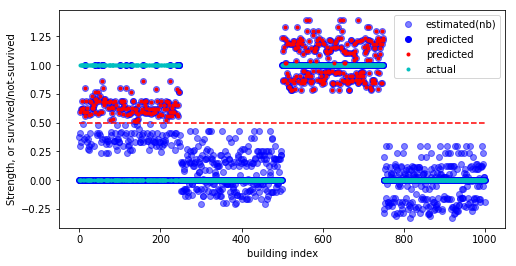

In [29]:
# and for our second toy-data set:
# (here, we see that it would be nicer to make a class into which we just plug our training data,
# target data, and any saleint prams.)
A_target2 = get_model_array(houses=target_houses2)
target_estimated2 = numpy.dot(A_target2, prms_predict[0])
bin_thresh2 = .5
target_estimated_binary2 = [int(x>bin_thresh) for x in target_estimated2]
target_actual2 = get_survived_vector_simple(houses=target_houses2, frac_failed=frac_fail)
#
#
plt.figure(figsize=(8,4))
plt.clf()
ax = plt.gca()
ax.plot(target_estimated2, marker='o', ls='', color='b', alpha=.5, label='estimated(nb)')
ax.plot(target_estimated_binary2, marker='o', ls='', color='b', alpha=1, label='predicted')
ax.plot([x if x>frac_fail else None for x in target_estimated2], marker='.', ls='', color='r',
        zorder=11, alpha=1, label='predicted')


ax.plot(target_actual2, marker='.', ls='', color='c', label='actual')
ax.plot([0, len(target_actual2)], [frac_fail, frac_fail], ls='--', color='r')
ax.legend(loc=0)
#
ax.set_xlabel('building index')
ax.set_ylabel('Strength, or survived/not-survived')

In [23]:
# how many did we get right?
# let's do a sloppy ROC type assessment: "h"it, "m"iss, "f"alse, "t"rue "negative".
#
roc_vals = []
a=0
b=0
c=0
d=0
# TODO: at least for small data sets, maybe simplify this code by using list.count(val)
for x1,x2 in zip(target_estimated_binary, target_actual): 
    if (x1==1 and x2==1):
        roc_vals += 'h'
        a+=1
    if (x1==0 and x2==0):
        # "true negative"
        roc_vals += 't'
        d+=1
    if (x1==1 and x2==0):
        roc_vals += 'f'
        b += 1
    if (x1==0 and x2==1):
        roc_vals += 'm'
        c+=1
    #
H = a/(a+c)
F = b/(b+d)
print('H={}, F={}, Skill={}'.format(H,F,H-F))
print('a={}, b={}, c={}, d={}'.format(a,b,c,d))
#print('aa={}, bb={}'.format(a/target_actual.count(1), b/target_estimated_binary.count(1) ))        


H=0.7535014005602241, F=0.0, Skill=0.7535014005602241
a=269, b=0, c=88, d=643


### *REALLY* Evaluate:
- In the previous example, we assumed a "hit" threshold of $z=0.5$ (or something like that), but the general output of the predictive model is continuous.
- Evaluate the ROC score for the full domain of threshold values, the plot -- like a regular ROC.
- For small data sets, we can do this the expensive way -- re-calculate the full $(H,F)$ over a domain of $z$.
- For large data sets, we require better optimization. Full ROC can be achieved in a single pass through the (sorted) prediction (forecast) and target sqeusnces.
- There are faster, smarter, more efficient ways to compute ROC, but this is pretty bullet proof, and for now, we're working with a small data set.
- Not surprisingly, this (crazy simple) toy model performs quite well under ROC.

##### NOTE: Since both the model and data are artificially quite 'correct,' it might be necessary to run this a few times to see any difference or imperfection in the ROC analysis.

In [24]:
def get_ROC_thresh(target_estimated, target_actual, n_thresh=250):
    FH = []
    for thresh in numpy.linspace(0., 1., 250):
        target_estimated_binary = [int(x>thresh) for x in target_estimated]
        roc_vals = []
        a=0
        b=0
        c=0
        d=0
        for x1,x2 in zip(target_estimated_binary, target_actual): 
            if (x1==1 and x2==1):
                roc_vals += 'h'
                a+=1
            if (x1==0 and x2==0):
                roc_vals += 't'
                d+=1
            if (x1==1 and x2==0):
                roc_vals += 'f'
                b += 1
            if (x1==0 and x2==1):
                roc_vals += 'm'
                c+=1
            #
        H = a/(a+c)
        F = b/(b+d)
        #
        FH += [[F,H]]
    #
    return FH
FH = get_ROC_thresh(target_estimated, target_actual)
FH2 = get_ROC_thresh(target_estimated2, target_actual2)
#

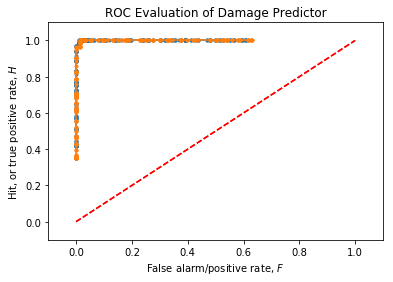

In [25]:
#
#
plt.figure()
plt.clf()
ax = plt.gca()
ax.plot(*zip(*FH), '.-')
ax.plot(range(2), range(2), ls='--', color='r')
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(-0.1, 1.1)

#plt.figure()
#plt.clf()
#ax = plt.gca()
ax.plot(*zip(*FH2), '.-')
ax.plot(range(2), range(2), ls='--', color='r')
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(-0.1, 1.1)

ax.set_title('ROC Evaluation of Damage Predictor')
ax.set_xlabel('False alarm/positive rate, $F$')
ax.set_ylabel('Hit, or true positive rate, $H$')